# **COCO2014 IMAGE CAPTIONING**

### **1. Import packages**

In [ ]:
pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import skimage.io as io
import pandas as pd
import plotly.express as px
from matplotlib.patches import Rectangle
from PIL import Image
import json
import random
from collections import Counter
import time
import re
import tensorflow as tf
from matplotlib import gridspec
import numpy as np
from tensorflow.keras import backend as k
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import RMSprop
import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from gtts import gTTS
import os
from IPython.display import Audio

### **2. Data import**

Only the **train split** will be imported and used for this project, since having all the splits offered by COCO is too computationally expensive. The dataset will then be spillted in training set, validation set and test set.

In [ ]:
dataset_train = foz.load_zoo_dataset("coco-2014", split="train")

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2014/train' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2014/tmp-download/annotations_trainval2014.zip'


 100% |██████|    1.9Gb/1.9Gb [2.8s elapsed, 0s remaining, 698.7Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [2.8s elapsed, 0s remaining, 698.7Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2014/raw/instances_train2014.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2014/raw/instances_train2014.json'


INFO:fiftyone.utils.coco:Downloading images to '/root/fiftyone/coco-2014/tmp-download/train2014.zip'


 100% |████|  100.7Gb/100.7Gb [4.1m elapsed, 0s remaining, 491.4Mb/s]      


INFO:eta.core.utils: 100% |████|  100.7Gb/100.7Gb [4.1m elapsed, 0s remaining, 491.4Mb/s]      


Extracting images to '/root/fiftyone/coco-2014/train/data'


INFO:fiftyone.utils.coco:Extracting images to '/root/fiftyone/coco-2014/train/data'


Writing annotations to '/root/fiftyone/coco-2014/train/labels.json'


INFO:fiftyone.utils.coco:Writing annotations to '/root/fiftyone/coco-2014/train/labels.json'


Dataset info written to '/root/fiftyone/coco-2014/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2014/info.json'


Loading 'coco-2014' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2014' split 'train'


 100% |█████████████| 82783/82783 [9.0m elapsed, 0s remaining, 113.7 samples/s]       


INFO:eta.core.utils: 100% |█████████████| 82783/82783 [9.0m elapsed, 0s remaining, 113.7 samples/s]       


Dataset 'coco-2014-train' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2014-train' created


### **3. Data exploration**

**Data overview**\
An **annotation** contains information about the elements in the image, such as its coordinates in the photo ans its category. \
A **category** is the label associated with the element. \
An **image** is a photo from which we extract knowledge.

Throughout the COCO API, we can access this information. In this context, `"ann"=annotation`, `"cat"=category`, and `"img"=image`.

- `COCO`: constructor of Microsoft COCO helper class for reading and visualizing annotations.

- `getAnnIds`: get  ann ids that satisfy given filter conditions.

- `getCatIds`: get cat ids that satisfy given filter conditions.

- `getImgIds`: get img ids that satisfy given filter conditions.

- `loadAnns`: load anns with the specified ids.

- `loadCats`: load cats with the specified ids.

- `loadImgs`: load imgs with the specified ids.

- `loadRes`: load algorithm results and create API for accessing them.

- `showAnns`: display the specified annotations.

Source: https://cocodataset.org/#download \
API functions details: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py \
Data format details: https://cocodataset.org/#download

A **caption** describes the content of a specific image, through the use of annotations. Each image has at least 5 captions. \

**Where to find the data**\
Once the COCO 2014 dataset is loaded, the information above can be found in different files. Here, we insert the data in folder `/root/fiftyone/coco-2014`.  In particular, such subfolder containd another folder
`data` with all the **images** and a JSON file `labels.json`, containing all the **annotations**, including thier categories.\
The **captions** can be found in the folder `/root/fiftyone/coco-2014/raw` in a file called `captions_train2014.json`.

**A brief overview of the data available**

In [ ]:
# Path to COCO annotations file (JSON format)
annotations_path = '/root/fiftyone/coco-2014/train/labels.json'
# Load COCO annotations
coco = COCO(annotations_path)
# Path to COCO training images directory
images_dir = '/root/fiftyone/coco-2014/train/data'

loading annotations into memory...
Done (t=11.57s)
creating index...
index created!


In [ ]:
with open('/root/fiftyone/coco-2014/raw/captions_train2014.json') as file:
    captions = json.load(file)
with open('/root/fiftyone/coco-2014/raw/instances_train2014.json') as file:
    instances = json.load(file)

Given a the train split, the function shows:
- the **5 captions** for the image
- a table containing all the **cagories** of the elements in it
- the **images**: the original one, the one with the masks (annotations points), anche the one with mask + label
In this way, we are able to understand the data we are working with.

In [ ]:
def random_image_infos():
    ## get all the ids and select a random one
    ids = coco.getImgIds()
    image_id = random.choice(ids)

    ## search and select the 5 captions of the image
    idx_cap = 0
    for i in captions['annotations']:
        if i['image_id'] == image_id:
            idx_cap += 1
            caption = i['caption']
            found = True
            print('Caption '+ str(idx_cap) + ': '+ caption)

    ## creates a table with the cateogries in the photo and their cardinality
    # get categories ids in the photo
    cat_id = []
    for i in range(0, len(instances['annotations'])):
        if instances['annotations'][i]['image_id'] == image_id:
          cat_id.append(instances['annotations'][i]['category_id'])

    # all the categories
    categories = coco.loadCats(coco.getCatIds())

    # associate category id to gategory name
    name=[]
    id=[]
    for i in cat_id:
        for j in categories:
            if i == j['id']:
                name.append(j['name'])
                id.append(j['id'])
    names = list(set(name))
    ids_cat = list(set(id))

    # create dataframe with category name, category id and count
    df_cat = pd.DataFrame(list(zip(name,id)),columns = ['category_names','category_id'])
    df_cat['count'] = 0
    counts = Counter(df_cat['category_names'])
    df_cat = df_cat.drop_duplicates()
    for n in df_cat['category_names']:
        for m in counts.keys():
            if n == m:
                df_cat.loc[df_cat['category_names'] == n, 'count'] = counts[m]

    df_cat.reset_index(drop=True, inplace=True)
    df_cat.columns = ['Category Name', 'Category Id', 'Count']
    display(df_cat)

    ## dispay images
    fig = plt.figure(figsize = (17, 8))
    gs = gridspec.GridSpec(1, 3, figure = fig)

    image_filename = images_dir +"/" +"COCO_train2014_"+ f'{str(image_id).zfill(12)}.jpg'
    image = Image.open(image_filename)

    # original photo
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(image)
    ax1.axis('off')

    # photo with masks (annotations)
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(image)
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)
    coco.showAnns(annotations)
    ax2.axis('off')

    # with masks (annotations) and label (cateogry name)
    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(image)
    ax3.axis('off')
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)
    coco.showAnns(annotations)
    image_annotations = [annotation for annotation in annotations if annotation['image_id'] == image_id]
    for annotation in image_annotations:
      bbox = annotation['bbox']
      x = bbox[0]
      y = bbox[1]
      for i in range(0,len(df_cat)):
        if annotation['category_id'] == df_cat["Category Id"][i]:
          label = df_cat["Category Name"][i]
          plt.text(x, y, label, backgroundcolor = 'white')

Caption 1: a man sitting at a table with some coffee, orange juice and a donut 
Caption 2: A smiling man sits at a table with a doughnut, coffee and juice.
Caption 3: Happy man with coffee, a donut and orange juice.
Caption 4: A man wearing glasses sitting behind a cup of coffee, glass of orange juice and a donut.
Caption 5: A man wearing glasses sitting at a table containing a bagel, juice, and coffee.


,Category Name,Category Id,Count
0,chair,62,1
1,dining table,67,1
2,cup,47,2
3,spoon,50,1
4,donut,60,1
5,person,1,3


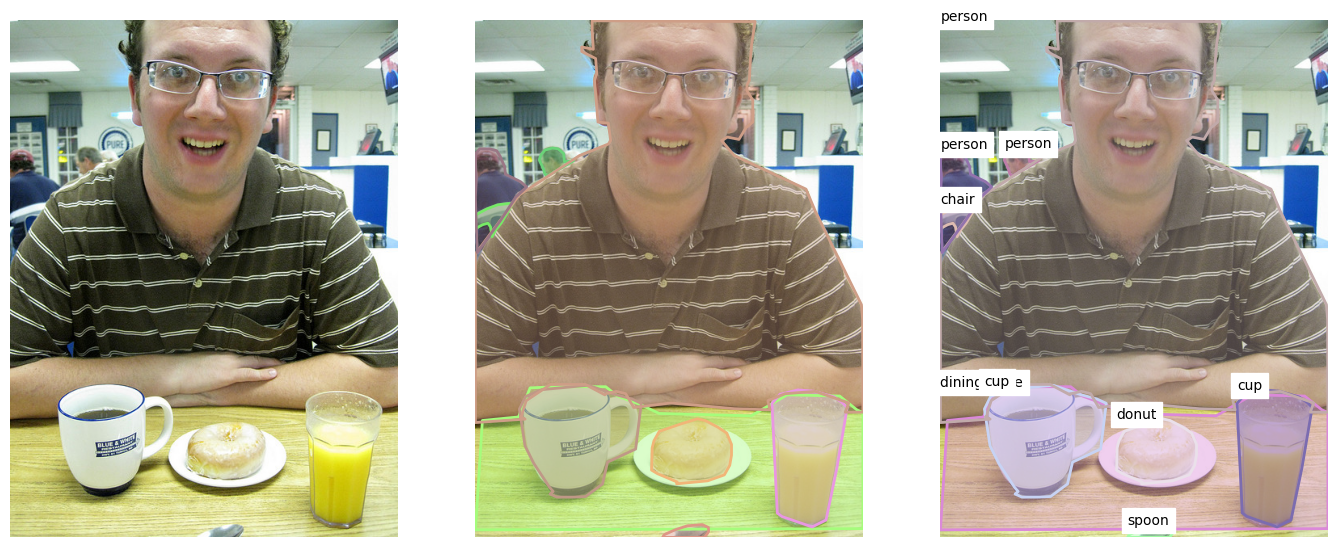

In [ ]:
random_image_infos()

**Categories**

We can get the list of available **categories and supercategories** in the dataset, which are the object in the photos.

In [ ]:
# get categories
categories = coco.loadCats(coco.getCatIds())

In [ ]:
category_id = 44  # Example of category ID
category_info = coco.loadCats(category_id)[0]
# print the information about the category
print(category_info['id'])
print(category_info['name'])
print(category_info['supercategory'])

44
bottle
kitchen


In total, there are **80 categories** grouped in **12 supercategories**.

In [ ]:
# create dataframe for plotly bar chart
category_names = [category['name'] for category in categories]
annotation_counts = [len(coco.getAnnIds(catIds=category['id'])) for category in categories]
supercategory_names= [category['supercategory'] for category in categories]
df_category=pd.DataFrame(list(zip(supercategory_names,category_names,annotation_counts)), columns = ['supercategory_names','category_names','annotation_counts'])
df_category

,supercategory_names,category_names,annotation_counts
0,person,person,185316
1,vehicle,bicycle,4955
2,vehicle,car,30785
3,vehicle,motorcycle,6021
4,vehicle,airplane,3833
...,...,...,...
75,indoor,vase,4623
76,indoor,scissors,1073
77,indoor,teddy bear,3442
78,indoor,hair drier,135


In [ ]:
fig = px.bar(df_category, x="supercategory_names", y="annotation_counts", color="category_names",
             title="Number of occurence per category",
             labels={
                     "supercategory_names": "Supercategory", # x-axis name
                     "annotation_counts": "Categories Count", # y-axis name
                     "category_names": "Categories" # legend name
                 },
             text="category_names", height=700)
fig.show()

### **4. Image-caption dataframe and splits creation**
Create a structure that contains images and captions.\
First column: *paths to images*\
Second column: *captions*

In [ ]:
## gets all the images paths
img_capts_list = []
for sample in captions['annotations']:
    img_name = '/root/fiftyone/coco-2014/train/data/COCO_train2014_' + '%012d.jpg' % sample['image_id'] #get the image name
    img_capts_list.append([img_name, sample['caption']])

In [ ]:
df = pd.DataFrame(img_capts_list, columns=['images', 'captions'])

As said before, each image has 5 captions bu we will take only one caption per image, so that the model has "*less options*" to train on.\
This dataframe is useful to **create the splits**.

In [ ]:
np.random.seed(10)
df = df.sort_values(by="images")
img_capts_df = df.loc[::5]
img_capts_df = shuffle(img_capts_df)
img_capts_df.reset_index(drop=True, inplace=True)

In [ ]:
img_capts_df

,images,captions
0,/root/fiftyone/coco-2014/train/data/COCO_train...,A pizza topped with broccoli and cheese restin...
1,/root/fiftyone/coco-2014/train/data/COCO_train...,Several surfers with surfboards at the beach g...
2,/root/fiftyone/coco-2014/train/data/COCO_train...,An old style church painted white and red next...
3,/root/fiftyone/coco-2014/train/data/COCO_train...,people walking on the sand of a beach shorelin...
4,/root/fiftyone/coco-2014/train/data/COCO_train...,Somebody looking at their texts on a flip tele...
...,...,...
82818,/root/fiftyone/coco-2014/train/data/COCO_train...,A large airplane sitting on a brown tarmac.
82819,/root/fiftyone/coco-2014/train/data/COCO_train...,A woman and child are leaning over a rail to l...
82820,/root/fiftyone/coco-2014/train/data/COCO_train...,The people are enjoying the segways in the cit...
82821,/root/fiftyone/coco-2014/train/data/COCO_train...,Silver and black kitchen stove under a matchin...


In order to check how out network performs, we need to create a training dataset, a validation dataset and a test dataset. \
In total, we have 83.000 images ca. and we will assign:
- 70% of the dataset to the training set;
- 20% of the dataset to the valisation set;
- 10% of the dataset to the test set.

In [ ]:
## train
len_train = int(len(img_capts_df)*0.7)
img_capts_df_train = img_capts_df[:len_train]
img_capts_df_train.reset_index(drop=True, inplace=True)
img_capts_df_train

,images,captions
0,/root/fiftyone/coco-2014/train/data/COCO_train...,A pizza topped with broccoli and cheese restin...
1,/root/fiftyone/coco-2014/train/data/COCO_train...,Several surfers with surfboards at the beach g...
2,/root/fiftyone/coco-2014/train/data/COCO_train...,An old style church painted white and red next...
3,/root/fiftyone/coco-2014/train/data/COCO_train...,people walking on the sand of a beach shorelin...
4,/root/fiftyone/coco-2014/train/data/COCO_train...,Somebody looking at their texts on a flip tele...
...,...,...
57971,/root/fiftyone/coco-2014/train/data/COCO_train...,A man brushing his teeth with a tooth brush.
57972,/root/fiftyone/coco-2014/train/data/COCO_train...,A couple of kiwi halves and an apple sitting o...
57973,/root/fiftyone/coco-2014/train/data/COCO_train...,The family is enjoying their family dinner tog...
57974,/root/fiftyone/coco-2014/train/data/COCO_train...,a cow grassing in a field with several other c...


In [ ]:
## validation
len_val=int(len(img_capts_df)*0.2 + len_train)
img_capts_df_val = img_capts_df[len_train:len_val]
img_capts_df_val.reset_index(drop=True, inplace=True)
img_capts_df_val

,images,captions
0,/root/fiftyone/coco-2014/train/data/COCO_train...,a woman standing by a window while talking on ...
1,/root/fiftyone/coco-2014/train/data/COCO_train...,A stack of some type of food on a pan
2,/root/fiftyone/coco-2014/train/data/COCO_train...,A skier is hitting the snow hard on their board.
3,/root/fiftyone/coco-2014/train/data/COCO_train...,A large bird perches on the seat of a bicycle.
4,/root/fiftyone/coco-2014/train/data/COCO_train...,"A man sleeping on a park bench, then a woman l..."
...,...,...
16559,/root/fiftyone/coco-2014/train/data/COCO_train...,Bananas and oranges and apples in a container.
16560,/root/fiftyone/coco-2014/train/data/COCO_train...,The Zebra was pictured looking at the camera.
16561,/root/fiftyone/coco-2014/train/data/COCO_train...,Two chocolate chip cookies with ice cream in t...
16562,/root/fiftyone/coco-2014/train/data/COCO_train...,a passenger bus heading toward City Campus tur...


In [ ]:
## test
img_capts_df_test = img_capts_df[len_val:]
img_capts_df_test.reset_index(drop=True, inplace=True)
img_capts_df_test

,images,captions
0,/root/fiftyone/coco-2014/train/data/COCO_train...,A snowboarder is completing a jump off a snow ...
1,/root/fiftyone/coco-2014/train/data/COCO_train...,tree is a man holding a small red guitar
2,/root/fiftyone/coco-2014/train/data/COCO_train...,there are two trains that are coming up the tr...
3,/root/fiftyone/coco-2014/train/data/COCO_train...,A group of young men fighting over a white fri...
4,/root/fiftyone/coco-2014/train/data/COCO_train...,A passanger bus stopped in front of another pa...
...,...,...
8278,/root/fiftyone/coco-2014/train/data/COCO_train...,A large airplane sitting on a brown tarmac.
8279,/root/fiftyone/coco-2014/train/data/COCO_train...,A woman and child are leaning over a rail to l...
8280,/root/fiftyone/coco-2014/train/data/COCO_train...,The people are enjoying the segways in the cit...
8281,/root/fiftyone/coco-2014/train/data/COCO_train...,Silver and black kitchen stove under a matchin...


### **5. Tokenization and vocabulary creation**

Our neural network expects the captions as **tokens**, and not as words. The caption preprocessing has the goal to provide the model the data in a way it can be elaborated.

In [ ]:
max_length = 40 # max caption length in words

def cap_prep(caption):
    caption = re.sub(r'[^\w\s]', '', caption)
    caption = '[start] ' + caption + ' [end]'
    return caption

In [ ]:
img_capts_df_train['captions'] = img_capts_df_train['captions'].apply(cap_prep)
img_capts_df_val['captions'] = img_capts_df_val['captions'].apply(cap_prep)
img_capts_df_test['captions'] = img_capts_df_test['captions'].apply(cap_prep)

<ipython-input-24-b24b5debdb2b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-b24b5debdb2b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-b24b5debdb2b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    standardize= 'lower',
    split = 'whitespace',
    output_sequence_length = max_length)

In [ ]:
tokenizer.adapt(img_capts_df_train['captions'])

In [ ]:
vocab_size = tokenizer.vocabulary_size()  # max vocabulaty length
print("Dictonaty lenght:", vocab_size)
print("First 10 most frequent words:", tokenizer.get_vocabulary()[0:10])

Dictonaty lenght: 11041
First 10 most frequent words: ['', '[UNK]', 'a', '[start]', '[end]', 'on', 'of', 'the', 'in', 'with']


These **functions** are able to convert a word and to its integer representation in the vocabulaty (`w2i`) and viceversa (`i2w`). We need them to predict the caption.

In [ ]:
w2i = {word: index for index, word in enumerate(tokenizer.get_vocabulary())}
i2w = {index: word for index, word in enumerate(tokenizer.get_vocabulary())}

In [ ]:
## example
print("Integer represeation for 'a':",w2i['a'])
print("Text representation for the index 3:", i2w[3])

Integer represeation for 'a': 2
Text representation for the index 3: [start]


### **6. Image preprocessing**

In order to be processed, also the images need to be in a specific format. The code below accomplish this purpose.

In [ ]:
def img_prep_feat_ext(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

In [ ]:
batch_size = 64 # for the batch function

def img_dataset_creation(images):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.map(img_prep_feat_ext, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(batch_size)
    return dataset

In [ ]:
## train images
train_im = img_dataset_creation(img_capts_df_train.iloc[:, 0])

In [ ]:
## validation images
val_im = img_dataset_creation(img_capts_df_val.iloc[:, 0])

In [ ]:
## test images
test_im = img_dataset_creation(img_capts_df_test.iloc[:, 0])

Now we have all the data in a valid format for our neural network.

### **7. CNN Model - encoder**

The first part of our model has to goal to **extract features** from the images, so that the the RNN can combine this input with the words of the captions.\
We chose to use the **VGG16**, since it provided better performances with respect to the other model we tested, that is the ResNet50.\
For completeness, also the building of the ResNet50 will be included here.

```
def cnn_model():
  image_model = tf.keras.applications.ResNet50(include_top=False,
                                                weights='imagenet')
  inputs = keras.Input(shape=(224, 224, 3))
  x1 = image_model(inputs)
  outputs = keras.layers.Dense(512, activation='relu')(x1)
  flat=keras.layers.Flatten()(outputs)
  dense=keras.layers.Dense(4096,activation='relu')(flat)
  net = keras.Model(inputs=inputs, outputs=dense)
  return net
```



Belowe we built the net we actually used for the project.\
We used a **pretrained VGG16** from which we removed the last layers in order to have as putput a flatten layer with dimension **(None, 4096)**.
We also added an **image augmentatoin** layer, with is defined below.

In [ ]:
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

The pipeline consists of three image augmentation layers:

- **RandomFlip("horizontal")**: Randomly flips the images horizontally, which means it can mirror the images along the vertical axis.

- **RandomRotation(0.2)**: Randomly rotates the images by a maximum angle of 0.2 radians. The rotation can be in either a clockwise or counterclockwise direction.

- **RandomContrast(0.3)**: Randomly adjusts the contrast of the images by a factor between 1 - 0.3 and 1 + 0.3. This helps in introducing variations in the contrast levels of the images.

In [ ]:
def cnn_model():

    image_model = tf.keras.applications.VGG16(include_top=True,
                                                weights='imagenet')
    input_layer = image_model.input
    image_augm=image_augmentation(input_layer)
    transfer_layer = image_model.get_layer('fc2')
    cnn_model = keras.models.Model(inputs = input_layer, outputs = transfer_layer.output)

    return cnn_model

In [ ]:
cnn = cnn_model()

553467096/553467096 [==============================] - 13s 0us/step


In [ ]:
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

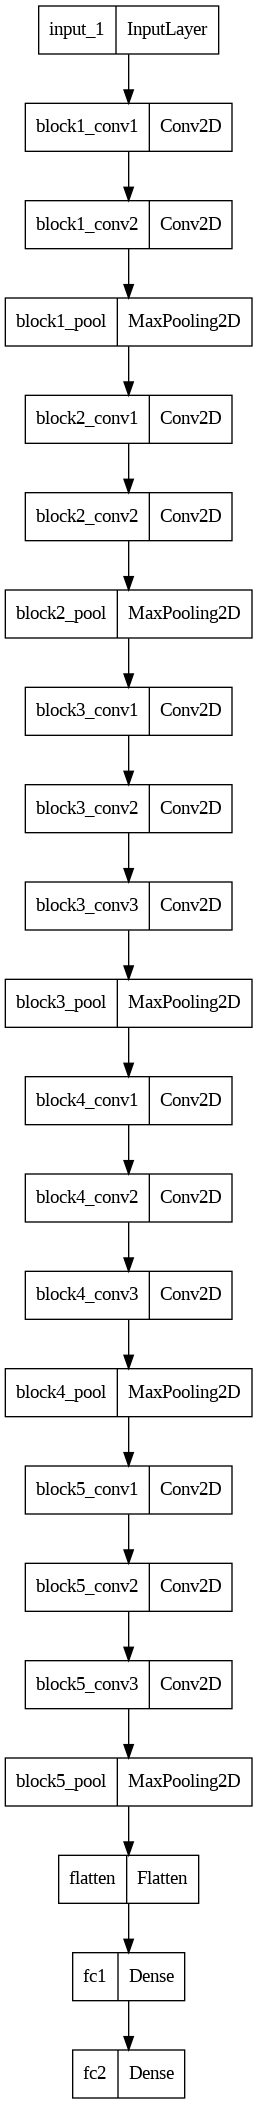

In [ ]:
keras.utils.plot_model(cnn, to_file='cnn.png')

**NOTE**: *we did not save this net on Google Drive, since there is no need to fit it. However, in the Google folder provided with the project is possible to find the predicted values from the CNN (see 9. Feature extraction) that were needed to fit the RNN , just in case you may need them. The predict, in fact, takes a while.*

### **8. RNN model (GRU) - decoder**

The **RNN with GRU layers** is responsible for actually generate the captions.\
Below is shown the code we used for the creation of the network.

In [ ]:
transfer_values_size = k.int_shape(cnn.output)[1]
transfer_values_size

4096

In [ ]:
decoder_input= keras.layers.Input(shape=(transfer_values_size),name='feature_input')
dense_to_gru=keras.layers.Dense(512, activation='tanh',name='dense_to_gru')
decoder_gru1 = GRU(512,return_sequences=True, reset_after = True)
decoder_gru2 = GRU(512,return_sequences=True, reset_after = True)
decoder_gru3 = GRU(512,return_sequences=True, reset_after = True)

In [ ]:
def rnn(output_cnn):
  gru_state = dense_to_gru(output_cnn)
  caption_input = keras.layers.Input(shape=(None,),name='caption_input')
  embedding_dec = keras.layers.Embedding(input_dim  =vocab_size, output_dim=128,name='embedding_dec')(caption_input)
  gru = decoder_gru1(embedding_dec, gru_state)
  drop = keras.layers.Dropout(0.2)(gru)
  gru1 = decoder_gru2(drop, gru_state)
  drop1 = keras.layers.Dropout(0.2)(gru1)
  gru2 = decoder_gru3(drop1, gru_state)
  dense_output=keras.layers.Dense(vocab_size, activation='softmax',name='dense_output')(gru2)
  rnn_model = keras.models.Model(inputs=[decoder_input,caption_input], outputs=dense_output)

  return rnn_model

In [ ]:
rnn_model = rnn(decoder_input)

In [ ]:
rnn_model.compile(optimizer=RMSprop(learning_rate=1e-3),
                      loss='sparse_categorical_crossentropy')

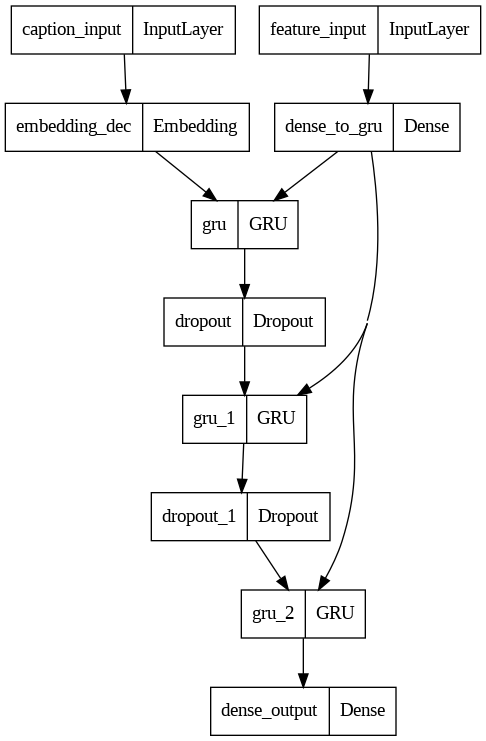

In [ ]:
keras.utils.plot_model(rnn_model, to_file='rnn.png')

In [ ]:
rnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 caption_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 feature_input (InputLayer)     [(None, 4096)]       0           []                               
                                                                                                  
 embedding_dec (Embedding)      (None, None, 128)    1413248     ['caption_input[0][0]']          
                                                                                                  
 dense_to_gru (Dense)           (None, 512)          2097664     ['feature_input[0][0]']          
                                                                                            

### **9. Feature extraction**

To speed up and simplify the implementation, the predicted features extracted with the VGG16 were saved on Google Drive.\
**HERE IS THE LINK:** https://drive.google.com/drive/folders/131QGSx1G8g84WjiWqAGLJgOwg_jwjDHd?usp=sharing \
*(The folder also contains the fitted RNN. Remember to put in on your personal Google Drive folder!)*.\
The data were saved on Drive with the following instrunctions:


```
## training dataset extracted features
transfer_values = cnn.predict(train_im)
np.save('/content/drive/My Drive/FDL_Cervini_Sabino/transfer_values.npy', transfer_values, allow_pickle=True)

## validation dataset extracted features
transfer_values_val = cnn.predict(val_im)
np.save('/content/drive/My Drive/FDL_Cervini_Sabino/transfer_values_val.npy', transfer_values_val, allow_pickle=True)

## testn dataset extracted features
transfer_values_test = cnn.predict(test_im)
np.save('/content/drive/My Drive/FDL_Cervini_Sabino/transfer_values_test.npy', transfer_values_test, allow_pickle=True)
```



Below the code to import the features. **We need them to generate the captions later!**

In [ ]:
# needed to connect notebook to your own Drive repository
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
transfer_values = np.load('/content/drive/My Drive/FDL_Cervini_Sabino/transfer_values.npy')

In [ ]:
transfer_values_val = np.load('/content/drive/My Drive/FDL_Cervini_Sabino/transfer_values_val.npy')

In [ ]:
transfer_values_test = np.load('/content/drive/My Drive/FDL_Cervini_Sabino/transfer_values_test.npy')

### **10. Model fitting**

**THE FITTED NEURAL NETWORK CAN BE FOUND HERE:** https://drive.google.com/drive/folders/131QGSx1G8g84WjiWqAGLJgOwg_jwjDHd?usp=sharing

In [ ]:
caption_input_train = tokenizer(img_capts_df_train['captions'])[:,:-1]
caption_input_train

In [ ]:
caption_target_train = tokenizer(img_capts_df_train['captions'])[:,1:]
caption_target_train

In [ ]:
caption_input_val = tokenizer(img_capts_df_val['captions'])[:,:-1]
caption_input_val

In [ ]:
caption_target_val = tokenizer(img_capts_df_val['captions'])[:,1:]
caption_target_val

In [ ]:
x_data = \
        {
            'feature_input': transfer_values,
            'caption_input': caption_input_train
        }

In [ ]:
x_data_val = \
        {
            'feature_input': transfer_values_val,
            'caption_input': caption_input_val
        }

Fit the model and set callbacks:



```
# Create a callback that saves the model's weights and implements early stopping
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("rnn_model.h5", verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

history = rnn_model.fit(x_data, caption_target_train, validation_data=(x_data_val, caption_target_val), epochs=20, callbacks = [callbacks])
```

The best model is found at

```
Epoch 9: val_loss improved from 0.87083 to 0.86760, saving model to rnn_model.h5
```





Once you add the folder on your own Google Drive, you can load the data with the following instruction.

In [ ]:
rnn_model = rnn(decoder_input)
rnn_model.load_weights("/content/drive/My Drive/FDL_Cervini_Sabino/rnn_model.h5")

### **11. Caption predict**

In [ ]:
def gen_cap(feature_input, max_tokens = 40):
  ## caption prediction
  shape = (1, max_tokens)
  decoder_input_data = np.zeros(shape=shape, dtype=int)
  token_int = w2i['[start]']
  token_end = w2i['[end]']
  output_text = ''
  count_tokens = 0
  while token_int != token_end and count_tokens < max_tokens:

        decoder_input_data[0, count_tokens] = token_int
        x_data = \
                  {'feature_input': feature_input,
                   'caption_input': decoder_input_data
                   }
        decoder_output = rnn_model.predict(x_data,verbose=0)

        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)

        sampled_word = i2w[token_int]

        output_text += " " + sampled_word

        count_tokens += 1

  # This is the sequence of tokens output by the decoder.
  output_tokens = decoder_input_data[0]
  return(output_text)

In [ ]:
def random_generate_caption():
  ids = range(0, len(img_capts_df_test))
  rand_id = random.choice(ids)
  image = Image.open(img_capts_df_test['images'][rand_id])
  real_capt = img_capts_df_test['captions'][rand_id]
  feature_input = transfer_values_test[[rand_id]]

  # predict caption
  smooth_fn = SmoothingFunction()
  pred = gen_cap(feature_input)
  token=img_capts_df_test['captions'][rand_id].split()
  pop=token.pop(0)
  ref_captions = token
  gen_captions = pred.split()
  score = sentence_bleu(ref_captions, gen_captions, smoothing_function=smooth_fn.method2)


  # print the captions
  print("Actual caption:", real_capt)
  print("Predicted caption:", pred)
  print("Pretty caption:", pred.lstrip().capitalize().rsplit(' ', 1)[0])
  print("this is the bleu score of the caption:",score)
  # show image
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  return pred

In [ ]:
caption_pred = random_generate_caption()

### **12. Extra: TTS**

In [ ]:
def generate_audio_prediction(caption):
    filename = "caption_pred.mp3"
    tts = gTTS(text=caption, lang='en')
    tts.save(os.path.join(audio_dir, filename))
    return os.path.join(audio_dir, filename)

In [ ]:
audio_dir = '/content/audio_captions'
os.makedirs(audio_dir, exist_ok=True)
audio_file = generate_audio_prediction(caption_pred)
Audio(audio_file)
